In [1]:
import time
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision.io import read_image
from torchvision.transforms import Resize, Compose, Normalize, Lambda
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.model_selection import train_test_split

# CNN Backbone
class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        self.feature_extractor = resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

# Transformer Model
class PoseTransformer(nn.Module):
    def __init__(self, num_keypoints, d_model=256, nhead=8, num_encoder_layers=6):
        super(PoseTransformer, self).__init__()
        self.d_model = d_model
        self.num_keypoints = num_keypoints
        self.keypoint_embedding = nn.Linear(2, d_model)
        cnn_output_size = 100352  # Fixed size based on flattened CNN output
        fusion_input_size = d_model * num_keypoints + cnn_output_size
        self.fusion_layer = nn.Linear(fusion_input_size, num_keypoints * d_model)
        encoder_layers = TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        self.pos_decoder = nn.Linear(d_model, 3)

    def forward(self, keypoints, cnn_features):
        keypoints = keypoints.view(-1, self.num_keypoints, 2)
        keypoint_embeddings = self.keypoint_embedding(keypoints)
        keypoint_embeddings = keypoint_embeddings.view(-1, self.d_model * self.num_keypoints)

        cnn_features = cnn_features.view(-1, 100352)  # Reshape to match the known flattened size

        combined_features = torch.cat((keypoint_embeddings, cnn_features), dim=1)
        combined_features = self.fusion_layer(combined_features)
        combined_features = combined_features.view(-1, self.num_keypoints, self.d_model)

        transformer_output = self.transformer_encoder(combined_features)
        output = self.pos_decoder(transformer_output)
        return output


class Keypoint3DModel(nn.Module):
    def __init__(self, num_keypoints):
        super(Keypoint3DModel, self).__init__()
        self.cnn_backbone = CNNBackbone()
        self.pose_transformer = PoseTransformer(num_keypoints)

    def forward(self, images, keypoints):
        cnn_features = self.cnn_backbone(images)
        cnn_features = torch.flatten(cnn_features, start_dim=1)
        output = self.pose_transformer(keypoints, cnn_features)
        return output


# Dataset Class
class MyDataset(Dataset):
    data_counter = 0
    
    def __init__(self, base_path, transform=None):
        self.base_path = base_path
        self.transform = transform
        self.filenames = [f.split('.')[0] for f in os.listdir(os.path.join(base_path, 'images'))]
        MyDataset.data_counter = 0

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        MyDataset.data_counter += 1
        total_data = len(self.filenames)
        print(f"Data loaded: {idx + 1} - {MyDataset.data_counter} / {total_data}")
        
        filename = self.filenames[idx]

        # Load image
        image_path = os.path.join(self.base_path, 'images', filename + '.png')
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)

        # Load 2D keypoints
        json_2d_path = os.path.join(self.base_path, 'mapping_2d', filename + '.json')
        with open(json_2d_path, 'r') as f:
            data_2d = json.load(f)

        # Convert keypoints to a tensor
        keypoints = torch.tensor([[kp['position']['x'], kp['position']['y']] for kp in data_2d['keypoints']], dtype=torch.float32)

        # Load 3D poses
        json_3d_path = os.path.join(self.base_path, 'mapping_3d', filename + '.json')
        with open(json_3d_path, 'r') as f:
            data_3d = json.load(f)

        # Convert 3D poses to a tensor
        poses = torch.tensor([[kp['position']['x'], kp['position']['y'], kp['position']['z']] for kp in data_3d['poses']], dtype=torch.float32)

        return image, keypoints, poses


# Loss Function and Optimizer
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        for batch_idx, (images, keypoints, poses) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images, keypoints)
            loss = criterion(outputs, poses)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 0:  # Log every 10 batches
                print(f"    Batch {batch_idx}: Training Loss = {loss.item()}")

        average_training_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Training Loss: {average_training_loss}")
        epoch_end_time = time.time()
        print(f"Epoch {epoch + 1} completed in {(epoch_end_time - epoch_start_time):.2f} seconds.")

        # Evaluate model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (images, keypoints, poses) in enumerate(val_loader):
                outputs = model(images, keypoints)
                loss = criterion(outputs, poses)
                val_loss += loss.item()
                if batch_idx % 10 == 0:  # Log every 10 batches
                    print(f"    Batch {batch_idx}: Validation Loss = {loss.item()}")

        average_validation_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}, Average Validation Loss: {average_validation_loss}")


In [2]:
# Example Usage
base_path = r"C:\Users\sakar\Semester Project\Spot Datasets\99 - Transformer 1"
transform = Compose([Resize((224, 224)),Lambda(lambda x: x.type(torch.FloatTensor)), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = MyDataset(base_path, transform=transform)
train_set, val_set = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

num_keypoints = 13  # Adjust based on your actual number of keypoints
model = Keypoint3DModel(num_keypoints=num_keypoints)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)
torch.save(model.state_dict(), 'poseformer.pth')

Data loaded: 4435 - 1 / 10000
Data loaded: 7111 - 2 / 10000
Data loaded: 4509 - 3 / 10000
Data loaded: 6751 - 4 / 10000


C:\Users\sakar\anaconda3\envs\mappertransformer\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Data loaded: 4248 - 5 / 10000
Data loaded: 912 - 6 / 10000
Data loaded: 6144 - 7 / 10000
Data loaded: 8746 - 8 / 10000
Data loaded: 8396 - 9 / 10000
Data loaded: 6858 - 10 / 10000
Data loaded: 6530 - 11 / 10000
Data loaded: 6522 - 12 / 10000
Data loaded: 351 - 13 / 10000
Data loaded: 696 - 14 / 10000
Data loaded: 6874 - 15 / 10000
Data loaded: 7888 - 16 / 10000
Data loaded: 8363 - 17 / 10000
Data loaded: 6265 - 18 / 10000
Data loaded: 7697 - 19 / 10000
Data loaded: 8533 - 20 / 10000
Data loaded: 2457 - 21 / 10000
Data loaded: 813 - 22 / 10000
Data loaded: 4702 - 23 / 10000
Data loaded: 8108 - 24 / 10000
Data loaded: 6880 - 25 / 10000
Data loaded: 7520 - 26 / 10000
Data loaded: 1869 - 27 / 10000
Data loaded: 8517 - 28 / 10000
Data loaded: 8913 - 29 / 10000
Data loaded: 3475 - 30 / 10000
Data loaded: 1828 - 31 / 10000
Data loaded: 6440 - 32 / 10000
Data loaded: 647 - 33 / 10000
Data loaded: 9934 - 34 / 10000
Data loaded: 3197 - 35 / 10000
Data loaded: 8716 - 36 / 10000
Data loaded: 12 - 

Data loaded: 6188 - 273 / 10000
Data loaded: 1172 - 274 / 10000
Data loaded: 1028 - 275 / 10000
Data loaded: 6331 - 276 / 10000
Data loaded: 7144 - 277 / 10000
Data loaded: 1252 - 278 / 10000
Data loaded: 3291 - 279 / 10000
Data loaded: 7230 - 280 / 10000
Data loaded: 1418 - 281 / 10000
Data loaded: 5960 - 282 / 10000
Data loaded: 8553 - 283 / 10000
Data loaded: 7116 - 284 / 10000
Data loaded: 5090 - 285 / 10000
Data loaded: 3903 - 286 / 10000
Data loaded: 9992 - 287 / 10000
Data loaded: 1755 - 288 / 10000
Data loaded: 7428 - 289 / 10000
Data loaded: 1565 - 290 / 10000
Data loaded: 4878 - 291 / 10000
Data loaded: 4863 - 292 / 10000
Data loaded: 3138 - 293 / 10000
Data loaded: 5356 - 294 / 10000
Data loaded: 6111 - 295 / 10000
Data loaded: 9541 - 296 / 10000
Data loaded: 1601 - 297 / 10000
Data loaded: 1149 - 298 / 10000
Data loaded: 502 - 299 / 10000
Data loaded: 6625 - 300 / 10000
Data loaded: 7039 - 301 / 10000
Data loaded: 546 - 302 / 10000
Data loaded: 9056 - 303 / 10000
Data loade

Data loaded: 7823 - 534 / 10000
Data loaded: 1669 - 535 / 10000
Data loaded: 8266 - 536 / 10000
Data loaded: 3353 - 537 / 10000
Data loaded: 5141 - 538 / 10000
Data loaded: 7195 - 539 / 10000
Data loaded: 4732 - 540 / 10000
Data loaded: 7850 - 541 / 10000
Data loaded: 3499 - 542 / 10000
Data loaded: 334 - 543 / 10000
Data loaded: 4772 - 544 / 10000
Data loaded: 2667 - 545 / 10000
Data loaded: 5034 - 546 / 10000
Data loaded: 8431 - 547 / 10000
Data loaded: 1027 - 548 / 10000
Data loaded: 7895 - 549 / 10000
Data loaded: 8580 - 550 / 10000
Data loaded: 7086 - 551 / 10000
Data loaded: 6678 - 552 / 10000
Data loaded: 2819 - 553 / 10000
Data loaded: 7885 - 554 / 10000
Data loaded: 8311 - 555 / 10000
Data loaded: 1973 - 556 / 10000
Data loaded: 236 - 557 / 10000
Data loaded: 3605 - 558 / 10000
Data loaded: 198 - 559 / 10000
Data loaded: 2083 - 560 / 10000
Data loaded: 4778 - 561 / 10000
Data loaded: 4335 - 562 / 10000
Data loaded: 3919 - 563 / 10000
Data loaded: 2597 - 564 / 10000
Data loaded

Data loaded: 9529 - 798 / 10000
Data loaded: 3528 - 799 / 10000
Data loaded: 8065 - 800 / 10000
Data loaded: 303 - 801 / 10000
Data loaded: 9099 - 802 / 10000
Data loaded: 4565 - 803 / 10000
Data loaded: 9833 - 804 / 10000
Data loaded: 9670 - 805 / 10000
Data loaded: 7799 - 806 / 10000
Data loaded: 479 - 807 / 10000
Data loaded: 1293 - 808 / 10000
Data loaded: 5876 - 809 / 10000
Data loaded: 1719 - 810 / 10000
Data loaded: 7269 - 811 / 10000
Data loaded: 8513 - 812 / 10000
Data loaded: 7709 - 813 / 10000
Data loaded: 3173 - 814 / 10000
Data loaded: 6353 - 815 / 10000
Data loaded: 8678 - 816 / 10000
Data loaded: 6323 - 817 / 10000
Data loaded: 5534 - 818 / 10000
Data loaded: 6059 - 819 / 10000
Data loaded: 162 - 820 / 10000
Data loaded: 7692 - 821 / 10000
Data loaded: 2064 - 822 / 10000
Data loaded: 7100 - 823 / 10000
Data loaded: 1951 - 824 / 10000
Data loaded: 4224 - 825 / 10000
Data loaded: 5142 - 826 / 10000
Data loaded: 7366 - 827 / 10000
Data loaded: 3399 - 828 / 10000
Data loaded

Data loaded: 7210 - 1059 / 10000
Data loaded: 2017 - 1060 / 10000
Data loaded: 2562 - 1061 / 10000
Data loaded: 4331 - 1062 / 10000
Data loaded: 1262 - 1063 / 10000
Data loaded: 3412 - 1064 / 10000
Data loaded: 5572 - 1065 / 10000
Data loaded: 9878 - 1066 / 10000
Data loaded: 9251 - 1067 / 10000
Data loaded: 4604 - 1068 / 10000
Data loaded: 2462 - 1069 / 10000
Data loaded: 3208 - 1070 / 10000
Data loaded: 8256 - 1071 / 10000
Data loaded: 7900 - 1072 / 10000
Data loaded: 3104 - 1073 / 10000
Data loaded: 8479 - 1074 / 10000
Data loaded: 3063 - 1075 / 10000
Data loaded: 3977 - 1076 / 10000
Data loaded: 8433 - 1077 / 10000
Data loaded: 4700 - 1078 / 10000
Data loaded: 6670 - 1079 / 10000
Data loaded: 3466 - 1080 / 10000
Data loaded: 3285 - 1081 / 10000
Data loaded: 7339 - 1082 / 10000
Data loaded: 2638 - 1083 / 10000
Data loaded: 7197 - 1084 / 10000
Data loaded: 9156 - 1085 / 10000
Data loaded: 8683 - 1086 / 10000
Data loaded: 5734 - 1087 / 10000
Data loaded: 4038 - 1088 / 10000
Data loade

Data loaded: 856 - 1311 / 10000
Data loaded: 2256 - 1312 / 10000
Data loaded: 6398 - 1313 / 10000
Data loaded: 3257 - 1314 / 10000
Data loaded: 8631 - 1315 / 10000
Data loaded: 2782 - 1316 / 10000
Data loaded: 7099 - 1317 / 10000
Data loaded: 8102 - 1318 / 10000
Data loaded: 3194 - 1319 / 10000
Data loaded: 6607 - 1320 / 10000
Data loaded: 9927 - 1321 / 10000
Data loaded: 908 - 1322 / 10000
Data loaded: 4456 - 1323 / 10000
Data loaded: 5735 - 1324 / 10000
Data loaded: 9110 - 1325 / 10000
Data loaded: 2644 - 1326 / 10000
Data loaded: 1873 - 1327 / 10000
Data loaded: 9419 - 1328 / 10000
Data loaded: 6928 - 1329 / 10000
Data loaded: 4271 - 1330 / 10000
Data loaded: 8869 - 1331 / 10000
Data loaded: 6039 - 1332 / 10000
Data loaded: 6820 - 1333 / 10000
Data loaded: 6498 - 1334 / 10000
Data loaded: 4962 - 1335 / 10000
Data loaded: 4626 - 1336 / 10000
Data loaded: 3617 - 1337 / 10000
Data loaded: 9338 - 1338 / 10000
Data loaded: 7792 - 1339 / 10000
Data loaded: 5403 - 1340 / 10000
Data loaded:

Data loaded: 3222 - 1563 / 10000
Data loaded: 2264 - 1564 / 10000
Data loaded: 4065 - 1565 / 10000
Data loaded: 2451 - 1566 / 10000
Data loaded: 5627 - 1567 / 10000
Data loaded: 2284 - 1568 / 10000
Data loaded: 7464 - 1569 / 10000
Data loaded: 2976 - 1570 / 10000
Data loaded: 4620 - 1571 / 10000
Data loaded: 2351 - 1572 / 10000
Data loaded: 249 - 1573 / 10000
Data loaded: 1332 - 1574 / 10000
Data loaded: 8868 - 1575 / 10000
Data loaded: 5089 - 1576 / 10000
Data loaded: 4440 - 1577 / 10000
Data loaded: 5858 - 1578 / 10000
Data loaded: 4966 - 1579 / 10000
Data loaded: 7392 - 1580 / 10000
Data loaded: 3183 - 1581 / 10000
Data loaded: 2416 - 1582 / 10000
Data loaded: 2261 - 1583 / 10000
Data loaded: 2911 - 1584 / 10000
Data loaded: 2227 - 1585 / 10000
Data loaded: 8384 - 1586 / 10000
Data loaded: 1920 - 1587 / 10000
Data loaded: 9306 - 1588 / 10000
Data loaded: 293 - 1589 / 10000
Data loaded: 955 - 1590 / 10000
Data loaded: 6280 - 1591 / 10000
Data loaded: 1989 - 1592 / 10000
Data loaded: 

Data loaded: 9416 - 1813 / 10000
Data loaded: 5962 - 1814 / 10000
Data loaded: 3108 - 1815 / 10000
Data loaded: 5866 - 1816 / 10000
Data loaded: 4142 - 1817 / 10000
Data loaded: 882 - 1818 / 10000
Data loaded: 8784 - 1819 / 10000
Data loaded: 9192 - 1820 / 10000
Data loaded: 2980 - 1821 / 10000
Data loaded: 2013 - 1822 / 10000
Data loaded: 2668 - 1823 / 10000
Data loaded: 9510 - 1824 / 10000
Data loaded: 988 - 1825 / 10000
Data loaded: 5869 - 1826 / 10000
Data loaded: 6333 - 1827 / 10000
Data loaded: 8035 - 1828 / 10000
Data loaded: 6219 - 1829 / 10000
Data loaded: 7625 - 1830 / 10000
Data loaded: 9965 - 1831 / 10000
Data loaded: 3032 - 1832 / 10000
Data loaded: 4054 - 1833 / 10000
Data loaded: 7192 - 1834 / 10000
Data loaded: 4596 - 1835 / 10000
Data loaded: 1158 - 1836 / 10000
Data loaded: 9329 - 1837 / 10000
Data loaded: 8169 - 1838 / 10000
Data loaded: 4994 - 1839 / 10000
Data loaded: 7982 - 1840 / 10000
Data loaded: 5434 - 1841 / 10000
Data loaded: 1706 - 1842 / 10000
Data loaded:

Data loaded: 5153 - 2067 / 10000
Data loaded: 4450 - 2068 / 10000
Data loaded: 2019 - 2069 / 10000
Data loaded: 9143 - 2070 / 10000
Data loaded: 3258 - 2071 / 10000
Data loaded: 886 - 2072 / 10000
Data loaded: 7879 - 2073 / 10000
Data loaded: 4306 - 2074 / 10000
Data loaded: 6783 - 2075 / 10000
Data loaded: 2827 - 2076 / 10000
Data loaded: 1465 - 2077 / 10000
Data loaded: 1214 - 2078 / 10000
Data loaded: 1477 - 2079 / 10000
Data loaded: 2141 - 2080 / 10000
Data loaded: 3575 - 2081 / 10000
Data loaded: 7334 - 2082 / 10000
Data loaded: 3641 - 2083 / 10000
Data loaded: 2048 - 2084 / 10000
Data loaded: 3083 - 2085 / 10000
Data loaded: 9952 - 2086 / 10000
Data loaded: 6262 - 2087 / 10000
Data loaded: 3112 - 2088 / 10000
Data loaded: 2405 - 2089 / 10000
Data loaded: 317 - 2090 / 10000
Data loaded: 2766 - 2091 / 10000
Data loaded: 6000 - 2092 / 10000
Data loaded: 3500 - 2093 / 10000
Data loaded: 1928 - 2094 / 10000
Data loaded: 7166 - 2095 / 10000
Data loaded: 6368 - 2096 / 10000
Data loaded:

Data loaded: 8207 - 2319 / 10000
Data loaded: 1253 - 2320 / 10000
Data loaded: 7164 - 2321 / 10000
Data loaded: 8757 - 2322 / 10000
Data loaded: 76 - 2323 / 10000
Data loaded: 8132 - 2324 / 10000
Data loaded: 5115 - 2325 / 10000
Data loaded: 7774 - 2326 / 10000
Data loaded: 4837 - 2327 / 10000
Data loaded: 1678 - 2328 / 10000
Data loaded: 6983 - 2329 / 10000
Data loaded: 3656 - 2330 / 10000
Data loaded: 8185 - 2331 / 10000
Data loaded: 2794 - 2332 / 10000
Data loaded: 3264 - 2333 / 10000
Data loaded: 5098 - 2334 / 10000
Data loaded: 3730 - 2335 / 10000
Data loaded: 7351 - 2336 / 10000
Data loaded: 788 - 2337 / 10000
Data loaded: 3512 - 2338 / 10000
Data loaded: 7422 - 2339 / 10000
Data loaded: 4153 - 2340 / 10000
Data loaded: 1854 - 2341 / 10000
Data loaded: 2276 - 2342 / 10000
Data loaded: 6492 - 2343 / 10000
Data loaded: 4924 - 2344 / 10000
Data loaded: 1762 - 2345 / 10000
Data loaded: 1857 - 2346 / 10000
Data loaded: 8702 - 2347 / 10000
Data loaded: 932 - 2348 / 10000
Data loaded: 7

Data loaded: 6999 - 2575 / 10000
Data loaded: 326 - 2576 / 10000
Data loaded: 4796 - 2577 / 10000
Data loaded: 7534 - 2578 / 10000
Data loaded: 5792 - 2579 / 10000
Data loaded: 1244 - 2580 / 10000
Data loaded: 5625 - 2581 / 10000
Data loaded: 4543 - 2582 / 10000
Data loaded: 7253 - 2583 / 10000
Data loaded: 8415 - 2584 / 10000
Data loaded: 1201 - 2585 / 10000
Data loaded: 4228 - 2586 / 10000
Data loaded: 3726 - 2587 / 10000
Data loaded: 3687 - 2588 / 10000
Data loaded: 1684 - 2589 / 10000
Data loaded: 9138 - 2590 / 10000
Data loaded: 8504 - 2591 / 10000
Data loaded: 4246 - 2592 / 10000
Data loaded: 909 - 2593 / 10000
Data loaded: 5582 - 2594 / 10000
Data loaded: 9186 - 2595 / 10000
Data loaded: 3837 - 2596 / 10000
Data loaded: 5979 - 2597 / 10000
Data loaded: 9865 - 2598 / 10000
Data loaded: 7671 - 2599 / 10000
Data loaded: 7969 - 2600 / 10000
Data loaded: 9390 - 2601 / 10000
Data loaded: 2381 - 2602 / 10000
Data loaded: 1634 - 2603 / 10000
Data loaded: 8245 - 2604 / 10000
Data loaded:

Data loaded: 8435 - 2831 / 10000
Data loaded: 4874 - 2832 / 10000
Data loaded: 7849 - 2833 / 10000
Data loaded: 1905 - 2834 / 10000
Data loaded: 9971 - 2835 / 10000
Data loaded: 1022 - 2836 / 10000
Data loaded: 9075 - 2837 / 10000
Data loaded: 7623 - 2838 / 10000
Data loaded: 3221 - 2839 / 10000
Data loaded: 6710 - 2840 / 10000
Data loaded: 845 - 2841 / 10000
Data loaded: 9112 - 2842 / 10000
Data loaded: 2610 - 2843 / 10000
Data loaded: 3540 - 2844 / 10000
Data loaded: 8085 - 2845 / 10000
Data loaded: 7600 - 2846 / 10000
Data loaded: 4566 - 2847 / 10000
Data loaded: 8175 - 2848 / 10000
Data loaded: 6627 - 2849 / 10000
Data loaded: 3823 - 2850 / 10000
Data loaded: 4451 - 2851 / 10000
Data loaded: 524 - 2852 / 10000
Data loaded: 6485 - 2853 / 10000
Data loaded: 9127 - 2854 / 10000
Data loaded: 6635 - 2855 / 10000
Data loaded: 169 - 2856 / 10000
Data loaded: 8353 - 2857 / 10000
Data loaded: 5899 - 2858 / 10000
Data loaded: 3199 - 2859 / 10000
Data loaded: 7113 - 2860 / 10000
Data loaded: 

Data loaded: 811 - 3081 / 10000
Data loaded: 4368 - 3082 / 10000
Data loaded: 6907 - 3083 / 10000
Data loaded: 6640 - 3084 / 10000
Data loaded: 1740 - 3085 / 10000
Data loaded: 7090 - 3086 / 10000
Data loaded: 7026 - 3087 / 10000
Data loaded: 787 - 3088 / 10000
Data loaded: 5975 - 3089 / 10000
Data loaded: 1126 - 3090 / 10000
Data loaded: 2713 - 3091 / 10000
Data loaded: 3121 - 3092 / 10000
Data loaded: 4896 - 3093 / 10000
Data loaded: 7457 - 3094 / 10000
Data loaded: 1514 - 3095 / 10000
Data loaded: 120 - 3096 / 10000
Data loaded: 1160 - 3097 / 10000
Data loaded: 8814 - 3098 / 10000
Data loaded: 5527 - 3099 / 10000
Data loaded: 1004 - 3100 / 10000
Data loaded: 6378 - 3101 / 10000
Data loaded: 1582 - 3102 / 10000
Data loaded: 873 - 3103 / 10000
Data loaded: 5590 - 3104 / 10000
Data loaded: 1782 - 3105 / 10000
Data loaded: 4017 - 3106 / 10000
Data loaded: 4273 - 3107 / 10000
Data loaded: 8837 - 3108 / 10000
Data loaded: 9557 - 3109 / 10000
Data loaded: 7112 - 3110 / 10000
Data loaded: 7

Data loaded: 3329 - 3332 / 10000
Data loaded: 8037 - 3333 / 10000
Data loaded: 6081 - 3334 / 10000
Data loaded: 561 - 3335 / 10000
Data loaded: 7044 - 3336 / 10000
Data loaded: 1645 - 3337 / 10000
Data loaded: 4776 - 3338 / 10000
Data loaded: 1908 - 3339 / 10000
Data loaded: 271 - 3340 / 10000
Data loaded: 5195 - 3341 / 10000
Data loaded: 4603 - 3342 / 10000
Data loaded: 9813 - 3343 / 10000
Data loaded: 9997 - 3344 / 10000
Data loaded: 5470 - 3345 / 10000
Data loaded: 3711 - 3346 / 10000
Data loaded: 1147 - 3347 / 10000
Data loaded: 6289 - 3348 / 10000
Data loaded: 8177 - 3349 / 10000
Data loaded: 360 - 3350 / 10000
Data loaded: 9215 - 3351 / 10000
Data loaded: 3511 - 3352 / 10000
Data loaded: 3307 - 3353 / 10000
Data loaded: 2938 - 3354 / 10000
Data loaded: 1377 - 3355 / 10000
Data loaded: 6686 - 3356 / 10000
Data loaded: 9713 - 3357 / 10000
Data loaded: 9465 - 3358 / 10000
Data loaded: 108 - 3359 / 10000
Data loaded: 3111 - 3360 / 10000
Data loaded: 7618 - 3361 / 10000
Data loaded: 7

Data loaded: 9908 - 3582 / 10000
Data loaded: 8778 - 3583 / 10000
Data loaded: 9137 - 3584 / 10000
Data loaded: 5598 - 3585 / 10000
Data loaded: 1676 - 3586 / 10000
Data loaded: 730 - 3587 / 10000
Data loaded: 1370 - 3588 / 10000
Data loaded: 2007 - 3589 / 10000
Data loaded: 1644 - 3590 / 10000
Data loaded: 7370 - 3591 / 10000
Data loaded: 2085 - 3592 / 10000
Data loaded: 6826 - 3593 / 10000
Data loaded: 1839 - 3594 / 10000
Data loaded: 6717 - 3595 / 10000
Data loaded: 2489 - 3596 / 10000
Data loaded: 9969 - 3597 / 10000
Data loaded: 2685 - 3598 / 10000
Data loaded: 3896 - 3599 / 10000
Data loaded: 4426 - 3600 / 10000
Data loaded: 6190 - 3601 / 10000
Data loaded: 325 - 3602 / 10000
Data loaded: 6502 - 3603 / 10000
Data loaded: 5871 - 3604 / 10000
Data loaded: 5163 - 3605 / 10000
Data loaded: 7684 - 3606 / 10000
Data loaded: 3008 - 3607 / 10000
Data loaded: 7708 - 3608 / 10000
Data loaded: 9284 - 3609 / 10000
Data loaded: 82 - 3610 / 10000
Data loaded: 1180 - 3611 / 10000
Data loaded: 7

Data loaded: 2314 - 3837 / 10000
Data loaded: 3559 - 3838 / 10000
Data loaded: 7756 - 3839 / 10000
Data loaded: 8652 - 3840 / 10000
Data loaded: 5036 - 3841 / 10000
Data loaded: 9323 - 3842 / 10000
Data loaded: 6181 - 3843 / 10000
Data loaded: 8952 - 3844 / 10000
Data loaded: 1002 - 3845 / 10000
Data loaded: 6605 - 3846 / 10000
Data loaded: 6082 - 3847 / 10000
Data loaded: 5707 - 3848 / 10000
Data loaded: 603 - 3849 / 10000
Data loaded: 3594 - 3850 / 10000
Data loaded: 2846 - 3851 / 10000
Data loaded: 3544 - 3852 / 10000
Data loaded: 7533 - 3853 / 10000
Data loaded: 2879 - 3854 / 10000
Data loaded: 5249 - 3855 / 10000
Data loaded: 3069 - 3856 / 10000
Data loaded: 5492 - 3857 / 10000
Data loaded: 9898 - 3858 / 10000
Data loaded: 8862 - 3859 / 10000
Data loaded: 6204 - 3860 / 10000
Data loaded: 8867 - 3861 / 10000
Data loaded: 8136 - 3862 / 10000
Data loaded: 3490 - 3863 / 10000
Data loaded: 7452 - 3864 / 10000
Data loaded: 5182 - 3865 / 10000
Data loaded: 791 - 3866 / 10000
Data loaded:

Data loaded: 1328 - 4092 / 10000
Data loaded: 3240 - 4093 / 10000
Data loaded: 4926 - 4094 / 10000
Data loaded: 2523 - 4095 / 10000
Data loaded: 4903 - 4096 / 10000
Data loaded: 9487 - 4097 / 10000
Data loaded: 4873 - 4098 / 10000
Data loaded: 3308 - 4099 / 10000
Data loaded: 1263 - 4100 / 10000
Data loaded: 9451 - 4101 / 10000
Data loaded: 5616 - 4102 / 10000
Data loaded: 3073 - 4103 / 10000
Data loaded: 3717 - 4104 / 10000
Data loaded: 9392 - 4105 / 10000
Data loaded: 4251 - 4106 / 10000
Data loaded: 6138 - 4107 / 10000
Data loaded: 3877 - 4108 / 10000
Data loaded: 4607 - 4109 / 10000
Data loaded: 8040 - 4110 / 10000
Data loaded: 3799 - 4111 / 10000
Data loaded: 5767 - 4112 / 10000
Data loaded: 5286 - 4113 / 10000
Data loaded: 6804 - 4114 / 10000
Data loaded: 7333 - 4115 / 10000
Data loaded: 73 - 4116 / 10000
Data loaded: 6587 - 4117 / 10000
Data loaded: 6467 - 4118 / 10000
Data loaded: 1471 - 4119 / 10000
Data loaded: 2856 - 4120 / 10000
Data loaded: 282 - 4121 / 10000
Data loaded: 

Data loaded: 9310 - 4348 / 10000
Data loaded: 4612 - 4349 / 10000
Data loaded: 8208 - 4350 / 10000
Data loaded: 9600 - 4351 / 10000
Data loaded: 710 - 4352 / 10000
Data loaded: 2987 - 4353 / 10000
Data loaded: 3051 - 4354 / 10000
Data loaded: 1943 - 4355 / 10000
Data loaded: 159 - 4356 / 10000
Data loaded: 7502 - 4357 / 10000
Data loaded: 8654 - 4358 / 10000
Data loaded: 9983 - 4359 / 10000
Data loaded: 7598 - 4360 / 10000
Data loaded: 192 - 4361 / 10000
Data loaded: 1139 - 4362 / 10000
Data loaded: 1626 - 4363 / 10000
Data loaded: 8134 - 4364 / 10000
Data loaded: 494 - 4365 / 10000
Data loaded: 728 - 4366 / 10000
Data loaded: 8238 - 4367 / 10000
Data loaded: 2372 - 4368 / 10000
Data loaded: 7214 - 4369 / 10000
Data loaded: 9333 - 4370 / 10000
Data loaded: 5936 - 4371 / 10000
Data loaded: 3970 - 4372 / 10000
Data loaded: 7959 - 4373 / 10000
Data loaded: 989 - 4374 / 10000
Data loaded: 7817 - 4375 / 10000
Data loaded: 8348 - 4376 / 10000
Data loaded: 7508 - 4377 / 10000
Data loaded: 495

Data loaded: 1369 - 4599 / 10000
Data loaded: 6550 - 4600 / 10000
Data loaded: 9275 - 4601 / 10000
Data loaded: 960 - 4602 / 10000
Data loaded: 2600 - 4603 / 10000
Data loaded: 3642 - 4604 / 10000
Data loaded: 5589 - 4605 / 10000
Data loaded: 8445 - 4606 / 10000
Data loaded: 620 - 4607 / 10000
Data loaded: 720 - 4608 / 10000
Data loaded: 165 - 4609 / 10000
Data loaded: 7081 - 4610 / 10000
Data loaded: 8890 - 4611 / 10000
Data loaded: 2770 - 4612 / 10000
Data loaded: 4072 - 4613 / 10000
Data loaded: 8563 - 4614 / 10000
Data loaded: 5389 - 4615 / 10000
Data loaded: 2750 - 4616 / 10000
Data loaded: 6384 - 4617 / 10000
Data loaded: 6980 - 4618 / 10000
Data loaded: 7401 - 4619 / 10000
Data loaded: 5256 - 4620 / 10000
Data loaded: 1922 - 4621 / 10000
Data loaded: 8583 - 4622 / 10000
Data loaded: 2110 - 4623 / 10000
Data loaded: 9553 - 4624 / 10000
Data loaded: 5933 - 4625 / 10000
Data loaded: 9062 - 4626 / 10000
Data loaded: 5291 - 4627 / 10000
Data loaded: 9814 - 4628 / 10000
Data loaded: 8

Data loaded: 3436 - 4851 / 10000
Data loaded: 9852 - 4852 / 10000
Data loaded: 8527 - 4853 / 10000
Data loaded: 315 - 4854 / 10000
Data loaded: 8877 - 4855 / 10000
Data loaded: 4709 - 4856 / 10000
Data loaded: 7233 - 4857 / 10000
Data loaded: 4983 - 4858 / 10000
Data loaded: 6191 - 4859 / 10000
Data loaded: 25 - 4860 / 10000
Data loaded: 4358 - 4861 / 10000
Data loaded: 9613 - 4862 / 10000
Data loaded: 7664 - 4863 / 10000
Data loaded: 8831 - 4864 / 10000
Data loaded: 7012 - 4865 / 10000
Data loaded: 7816 - 4866 / 10000
Data loaded: 6662 - 4867 / 10000
Data loaded: 5884 - 4868 / 10000
Data loaded: 9483 - 4869 / 10000
Data loaded: 9586 - 4870 / 10000
Data loaded: 5762 - 4871 / 10000
Data loaded: 6189 - 4872 / 10000
Data loaded: 231 - 4873 / 10000
Data loaded: 7953 - 4874 / 10000
Data loaded: 2222 - 4875 / 10000
Data loaded: 9656 - 4876 / 10000
Data loaded: 7018 - 4877 / 10000
Data loaded: 6244 - 4878 / 10000
Data loaded: 8283 - 4879 / 10000
Data loaded: 2947 - 4880 / 10000
Data loaded: 5

Data loaded: 3117 - 5107 / 10000
Data loaded: 5300 - 5108 / 10000
Data loaded: 9273 - 5109 / 10000
Data loaded: 6047 - 5110 / 10000
Data loaded: 2080 - 5111 / 10000
Data loaded: 8998 - 5112 / 10000
Data loaded: 250 - 5113 / 10000
Data loaded: 3161 - 5114 / 10000
Data loaded: 4686 - 5115 / 10000
Data loaded: 1298 - 5116 / 10000
Data loaded: 2511 - 5117 / 10000
Data loaded: 9356 - 5118 / 10000
Data loaded: 3542 - 5119 / 10000
Data loaded: 9055 - 5120 / 10000
Data loaded: 9543 - 5121 / 10000
Data loaded: 4684 - 5122 / 10000
Data loaded: 6022 - 5123 / 10000
Data loaded: 9312 - 5124 / 10000
Data loaded: 423 - 5125 / 10000
Data loaded: 7518 - 5126 / 10000
Data loaded: 7688 - 5127 / 10000
Data loaded: 8059 - 5128 / 10000
Data loaded: 7882 - 5129 / 10000
Data loaded: 4015 - 5130 / 10000
Data loaded: 4125 - 5131 / 10000
Data loaded: 9011 - 5132 / 10000
Data loaded: 7178 - 5133 / 10000
Data loaded: 2166 - 5134 / 10000
Data loaded: 7876 - 5135 / 10000
Data loaded: 440 - 5136 / 10000
Data loaded: 

Data loaded: 7717 - 5363 / 10000
Data loaded: 7615 - 5364 / 10000
Data loaded: 7845 - 5365 / 10000
Data loaded: 9459 - 5366 / 10000
Data loaded: 9362 - 5367 / 10000
Data loaded: 2192 - 5368 / 10000
Data loaded: 1199 - 5369 / 10000
Data loaded: 7359 - 5370 / 10000
Data loaded: 5471 - 5371 / 10000
Data loaded: 1933 - 5372 / 10000
Data loaded: 1155 - 5373 / 10000
Data loaded: 5148 - 5374 / 10000
Data loaded: 4892 - 5375 / 10000
Data loaded: 3229 - 5376 / 10000
Data loaded: 9198 - 5377 / 10000
Data loaded: 8797 - 5378 / 10000
Data loaded: 2359 - 5379 / 10000
Data loaded: 5853 - 5380 / 10000
Data loaded: 4493 - 5381 / 10000
Data loaded: 2700 - 5382 / 10000
Data loaded: 5725 - 5383 / 10000
Data loaded: 4470 - 5384 / 10000
Data loaded: 1458 - 5385 / 10000
Data loaded: 9317 - 5386 / 10000
Data loaded: 9351 - 5387 / 10000
Data loaded: 1439 - 5388 / 10000
Data loaded: 8956 - 5389 / 10000
Data loaded: 2514 - 5390 / 10000
Data loaded: 2107 - 5391 / 10000
Data loaded: 6828 - 5392 / 10000
Data loade

Data loaded: 7693 - 5617 / 10000
Data loaded: 6141 - 5618 / 10000
Data loaded: 2556 - 5619 / 10000
Data loaded: 2056 - 5620 / 10000
Data loaded: 1236 - 5621 / 10000
Data loaded: 8886 - 5622 / 10000
Data loaded: 9823 - 5623 / 10000
Data loaded: 829 - 5624 / 10000
Data loaded: 3613 - 5625 / 10000
Data loaded: 8446 - 5626 / 10000
Data loaded: 4002 - 5627 / 10000
Data loaded: 4261 - 5628 / 10000
Data loaded: 5233 - 5629 / 10000
Data loaded: 6943 - 5630 / 10000
Data loaded: 1045 - 5631 / 10000
Data loaded: 8449 - 5632 / 10000
Data loaded: 2616 - 5633 / 10000
Data loaded: 6845 - 5634 / 10000
Data loaded: 9469 - 5635 / 10000
Data loaded: 9775 - 5636 / 10000
Data loaded: 6071 - 5637 / 10000
Data loaded: 6503 - 5638 / 10000
Data loaded: 6366 - 5639 / 10000
Data loaded: 4035 - 5640 / 10000
Data loaded: 3252 - 5641 / 10000
Data loaded: 1454 - 5642 / 10000
Data loaded: 6786 - 5643 / 10000
Data loaded: 350 - 5644 / 10000
Data loaded: 9184 - 5645 / 10000
Data loaded: 9243 - 5646 / 10000
Data loaded:

Data loaded: 8720 - 5869 / 10000
Data loaded: 5162 - 5870 / 10000
Data loaded: 973 - 5871 / 10000
Data loaded: 4148 - 5872 / 10000
Data loaded: 4920 - 5873 / 10000
Data loaded: 2431 - 5874 / 10000
Data loaded: 6743 - 5875 / 10000
Data loaded: 6293 - 5876 / 10000
Data loaded: 9303 - 5877 / 10000
Data loaded: 9444 - 5878 / 10000
Data loaded: 7793 - 5879 / 10000
Data loaded: 2894 - 5880 / 10000
Data loaded: 9117 - 5881 / 10000
Data loaded: 5950 - 5882 / 10000
Data loaded: 5862 - 5883 / 10000
Data loaded: 1206 - 5884 / 10000
Data loaded: 8487 - 5885 / 10000
Data loaded: 2325 - 5886 / 10000
Data loaded: 3267 - 5887 / 10000
Data loaded: 421 - 5888 / 10000
Data loaded: 6867 - 5889 / 10000
Data loaded: 9583 - 5890 / 10000
Data loaded: 7227 - 5891 / 10000
Data loaded: 7894 - 5892 / 10000
Data loaded: 2695 - 5893 / 10000
Data loaded: 14 - 5894 / 10000
Data loaded: 3019 - 5895 / 10000
Data loaded: 10000 - 5896 / 10000
Data loaded: 1453 - 5897 / 10000
Data loaded: 7557 - 5898 / 10000
Data loaded: 

Data loaded: 3239 - 6121 / 10000
Data loaded: 3743 - 6122 / 10000
Data loaded: 5651 - 6123 / 10000
Data loaded: 3819 - 6124 / 10000
Data loaded: 6673 - 6125 / 10000
Data loaded: 756 - 6126 / 10000
Data loaded: 3839 - 6127 / 10000
Data loaded: 3510 - 6128 / 10000
Data loaded: 5620 - 6129 / 10000
Data loaded: 8151 - 6130 / 10000
Data loaded: 1630 - 6131 / 10000
Data loaded: 207 - 6132 / 10000
Data loaded: 7023 - 6133 / 10000
Data loaded: 9363 - 6134 / 10000
Data loaded: 7501 - 6135 / 10000
Data loaded: 9277 - 6136 / 10000
Data loaded: 8899 - 6137 / 10000
Data loaded: 8567 - 6138 / 10000
Data loaded: 872 - 6139 / 10000
Data loaded: 6780 - 6140 / 10000
Data loaded: 3361 - 6141 / 10000
Data loaded: 608 - 6142 / 10000
Data loaded: 4651 - 6143 / 10000
Data loaded: 6766 - 6144 / 10000
Data loaded: 7391 - 6145 / 10000
Data loaded: 3679 - 6146 / 10000
Data loaded: 3039 - 6147 / 10000
Data loaded: 5178 - 6148 / 10000
Data loaded: 2792 - 6149 / 10000
Data loaded: 3371 - 6150 / 10000
Data loaded: 2

Data loaded: 3722 - 6371 / 10000
Data loaded: 122 - 6372 / 10000
Data loaded: 3804 - 6373 / 10000
Data loaded: 7256 - 6374 / 10000
Data loaded: 1280 - 6375 / 10000
Data loaded: 8327 - 6376 / 10000
Data loaded: 269 - 6377 / 10000
Data loaded: 9240 - 6378 / 10000
Data loaded: 5022 - 6379 / 10000
Data loaded: 4851 - 6380 / 10000
Data loaded: 3824 - 6381 / 10000
Data loaded: 7211 - 6382 / 10000
Data loaded: 6793 - 6383 / 10000
Data loaded: 4492 - 6384 / 10000
Data loaded: 9519 - 6385 / 10000
Data loaded: 6529 - 6386 / 10000
Data loaded: 196 - 6387 / 10000
Data loaded: 9203 - 6388 / 10000
Data loaded: 650 - 6389 / 10000
Data loaded: 9591 - 6390 / 10000
Data loaded: 8054 - 6391 / 10000
Data loaded: 7859 - 6392 / 10000
Data loaded: 2142 - 6393 / 10000
Data loaded: 7659 - 6394 / 10000
Data loaded: 1900 - 6395 / 10000
Data loaded: 8043 - 6396 / 10000
Data loaded: 9040 - 6397 / 10000
Data loaded: 7585 - 6398 / 10000
Data loaded: 1191 - 6399 / 10000
Data loaded: 7906 - 6400 / 10000
Data loaded: 1

Data loaded: 9330 - 6628 / 10000
Data loaded: 5213 - 6629 / 10000
Data loaded: 8989 - 6630 / 10000
Data loaded: 4444 - 6631 / 10000
Data loaded: 8530 - 6632 / 10000
Data loaded: 7372 - 6633 / 10000
Data loaded: 3855 - 6634 / 10000
Data loaded: 1952 - 6635 / 10000
Data loaded: 9732 - 6636 / 10000
Data loaded: 7262 - 6637 / 10000
Data loaded: 1143 - 6638 / 10000
Data loaded: 804 - 6639 / 10000
Data loaded: 4432 - 6640 / 10000
Data loaded: 8082 - 6641 / 10000
Data loaded: 9296 - 6642 / 10000
Data loaded: 3182 - 6643 / 10000
Data loaded: 7412 - 6644 / 10000
Data loaded: 5844 - 6645 / 10000
Data loaded: 5400 - 6646 / 10000
Data loaded: 2410 - 6647 / 10000
Data loaded: 5311 - 6648 / 10000
Data loaded: 2053 - 6649 / 10000
Data loaded: 2472 - 6650 / 10000
Data loaded: 6618 - 6651 / 10000
Data loaded: 706 - 6652 / 10000
Data loaded: 3550 - 6653 / 10000
Data loaded: 8302 - 6654 / 10000
Data loaded: 8451 - 6655 / 10000
Data loaded: 2012 - 6656 / 10000
Data loaded: 3059 - 6657 / 10000
Data loaded:

Data loaded: 8042 - 6877 / 10000
Data loaded: 7555 - 6878 / 10000
Data loaded: 8774 - 6879 / 10000
Data loaded: 5847 - 6880 / 10000
Data loaded: 8752 - 6881 / 10000
Data loaded: 34 - 6882 / 10000
Data loaded: 2929 - 6883 / 10000
Data loaded: 8318 - 6884 / 10000
Data loaded: 497 - 6885 / 10000
Data loaded: 8569 - 6886 / 10000
Data loaded: 7453 - 6887 / 10000
Data loaded: 6884 - 6888 / 10000
Data loaded: 8155 - 6889 / 10000
Data loaded: 1917 - 6890 / 10000
Data loaded: 5133 - 6891 / 10000
Data loaded: 3215 - 6892 / 10000
Data loaded: 2923 - 6893 / 10000
Data loaded: 8815 - 6894 / 10000
Data loaded: 9445 - 6895 / 10000
Data loaded: 1818 - 6896 / 10000
Data loaded: 6688 - 6897 / 10000
Data loaded: 1306 - 6898 / 10000
Data loaded: 8639 - 6899 / 10000
Data loaded: 9738 - 6900 / 10000
Data loaded: 399 - 6901 / 10000
Data loaded: 431 - 6902 / 10000
Data loaded: 9939 - 6903 / 10000
Data loaded: 6006 - 6904 / 10000
Data loaded: 7179 - 6905 / 10000
Data loaded: 746 - 6906 / 10000
Data loaded: 319

Data loaded: 722 - 7132 / 10000
Data loaded: 2072 - 7133 / 10000
Data loaded: 52 - 7134 / 10000
Data loaded: 6482 - 7135 / 10000
Data loaded: 5701 - 7136 / 10000
Data loaded: 492 - 7137 / 10000
Data loaded: 7560 - 7138 / 10000
Data loaded: 8983 - 7139 / 10000
Data loaded: 4917 - 7140 / 10000
Data loaded: 9030 - 7141 / 10000
Data loaded: 1344 - 7142 / 10000
Data loaded: 1391 - 7143 / 10000
Data loaded: 5639 - 7144 / 10000
Data loaded: 1178 - 7145 / 10000
Data loaded: 2906 - 7146 / 10000
Data loaded: 4164 - 7147 / 10000
Data loaded: 7356 - 7148 / 10000
Data loaded: 8224 - 7149 / 10000
Data loaded: 1947 - 7150 / 10000
Data loaded: 2944 - 7151 / 10000
Data loaded: 3163 - 7152 / 10000
Data loaded: 6125 - 7153 / 10000
Data loaded: 8889 - 7154 / 10000
Data loaded: 4895 - 7155 / 10000
Data loaded: 1459 - 7156 / 10000
Data loaded: 6271 - 7157 / 10000
Data loaded: 4824 - 7158 / 10000
Data loaded: 8521 - 7159 / 10000
Data loaded: 2602 - 7160 / 10000
Data loaded: 4424 - 7161 / 10000
Data loaded: 4

Data loaded: 7834 - 7384 / 10000
Data loaded: 5860 - 7385 / 10000
Data loaded: 996 - 7386 / 10000
Data loaded: 2585 - 7387 / 10000
Data loaded: 3342 - 7388 / 10000
Data loaded: 628 - 7389 / 10000
Data loaded: 3615 - 7390 / 10000
Data loaded: 2271 - 7391 / 10000
Data loaded: 6855 - 7392 / 10000
Data loaded: 7061 - 7393 / 10000
Data loaded: 3228 - 7394 / 10000
Data loaded: 7186 - 7395 / 10000
Data loaded: 3590 - 7396 / 10000
Data loaded: 4403 - 7397 / 10000
Data loaded: 4820 - 7398 / 10000
Data loaded: 9799 - 7399 / 10000
Data loaded: 417 - 7400 / 10000
Data loaded: 4597 - 7401 / 10000
Data loaded: 5444 - 7402 / 10000
Data loaded: 3749 - 7403 / 10000
Data loaded: 1523 - 7404 / 10000
Data loaded: 9653 - 7405 / 10000
Data loaded: 3448 - 7406 / 10000
Data loaded: 6875 - 7407 / 10000
Data loaded: 9068 - 7408 / 10000
Data loaded: 2646 - 7409 / 10000
Data loaded: 8038 - 7410 / 10000
Data loaded: 3391 - 7411 / 10000
Data loaded: 8609 - 7412 / 10000
Data loaded: 1831 - 7413 / 10000
Data loaded: 

Data loaded: 9596 - 7642 / 10000
Data loaded: 3105 - 7643 / 10000
Data loaded: 6623 - 7644 / 10000
Data loaded: 2570 - 7645 / 10000
Data loaded: 9111 - 7646 / 10000
Data loaded: 3885 - 7647 / 10000
Data loaded: 6058 - 7648 / 10000
Data loaded: 4667 - 7649 / 10000
Data loaded: 2433 - 7650 / 10000
Data loaded: 3551 - 7651 / 10000
Data loaded: 2561 - 7652 / 10000
Data loaded: 7306 - 7653 / 10000
Data loaded: 4585 - 7654 / 10000
Data loaded: 319 - 7655 / 10000
Data loaded: 2518 - 7656 / 10000
Data loaded: 4049 - 7657 / 10000
Data loaded: 8167 - 7658 / 10000
Data loaded: 9917 - 7659 / 10000
Data loaded: 9753 - 7660 / 10000
Data loaded: 7521 - 7661 / 10000
Data loaded: 8796 - 7662 / 10000
Data loaded: 2491 - 7663 / 10000
Data loaded: 6840 - 7664 / 10000
Data loaded: 5451 - 7665 / 10000
Data loaded: 5742 - 7666 / 10000
Data loaded: 1395 - 7667 / 10000
Data loaded: 8321 - 7668 / 10000
Data loaded: 2339 - 7669 / 10000
Data loaded: 1864 - 7670 / 10000
Data loaded: 5070 - 7671 / 10000
Data loaded

Data loaded: 713 - 7893 / 10000
Data loaded: 7103 - 7894 / 10000
Data loaded: 632 - 7895 / 10000
Data loaded: 6220 - 7896 / 10000
Data loaded: 1720 - 7897 / 10000
Data loaded: 7516 - 7898 / 10000
Data loaded: 5164 - 7899 / 10000
Data loaded: 375 - 7900 / 10000
Data loaded: 8685 - 7901 / 10000
Data loaded: 3790 - 7902 / 10000
Data loaded: 5714 - 7903 / 10000
Data loaded: 8579 - 7904 / 10000
Data loaded: 2455 - 7905 / 10000
Data loaded: 7809 - 7906 / 10000
Data loaded: 6939 - 7907 / 10000
Data loaded: 5343 - 7908 / 10000
Data loaded: 7118 - 7909 / 10000
Data loaded: 4947 - 7910 / 10000
Data loaded: 5292 - 7911 / 10000
Data loaded: 3047 - 7912 / 10000
Data loaded: 1836 - 7913 / 10000
Data loaded: 6372 - 7914 / 10000
Data loaded: 651 - 7915 / 10000
Data loaded: 8391 - 7916 / 10000
Data loaded: 3388 - 7917 / 10000
Data loaded: 6396 - 7918 / 10000
Data loaded: 7973 - 7919 / 10000
Data loaded: 3914 - 7920 / 10000
Data loaded: 1808 - 7921 / 10000
Data loaded: 6413 - 7922 / 10000
Data loaded: 3

Data loaded: 8986 - 8148 / 10000
Data loaded: 1161 - 8149 / 10000
Data loaded: 9651 - 8150 / 10000
Data loaded: 227 - 8151 / 10000
Data loaded: 5236 - 8152 / 10000
Data loaded: 2693 - 8153 / 10000
Data loaded: 405 - 8154 / 10000
Data loaded: 6468 - 8155 / 10000
Data loaded: 6315 - 8156 / 10000
Data loaded: 5107 - 8157 / 10000
Data loaded: 841 - 8158 / 10000
Data loaded: 712 - 8159 / 10000
Data loaded: 9229 - 8160 / 10000
Data loaded: 3751 - 8161 / 10000
Data loaded: 1190 - 8162 / 10000
Data loaded: 1303 - 8163 / 10000
Data loaded: 338 - 8164 / 10000
Data loaded: 5052 - 8165 / 10000
Data loaded: 518 - 8166 / 10000
Data loaded: 2818 - 8167 / 10000
Data loaded: 5268 - 8168 / 10000
Data loaded: 1845 - 8169 / 10000
Data loaded: 4968 - 8170 / 10000
Data loaded: 9418 - 8171 / 10000
Data loaded: 3206 - 8172 / 10000
Data loaded: 4207 - 8173 / 10000
Data loaded: 4963 - 8174 / 10000
Data loaded: 7781 - 8175 / 10000
Data loaded: 2033 - 8176 / 10000
Data loaded: 9425 - 8177 / 10000
Data loaded: 731

Data loaded: 1725 - 8398 / 10000
Data loaded: 4029 - 8399 / 10000
Data loaded: 5780 - 8400 / 10000
Data loaded: 220 - 8401 / 10000
Data loaded: 8229 - 8402 / 10000
Data loaded: 8637 - 8403 / 10000
Data loaded: 6169 - 8404 / 10000
Data loaded: 6110 - 8405 / 10000
Data loaded: 953 - 8406 / 10000
Data loaded: 3530 - 8407 / 10000
Data loaded: 9856 - 8408 / 10000
Data loaded: 8486 - 8409 / 10000
Data loaded: 5497 - 8410 / 10000
Data loaded: 2388 - 8411 / 10000
Data loaded: 8633 - 8412 / 10000
Data loaded: 4876 - 8413 / 10000
Data loaded: 3185 - 8414 / 10000
Data loaded: 5564 - 8415 / 10000
Data loaded: 6569 - 8416 / 10000
Data loaded: 5810 - 8417 / 10000
Data loaded: 6299 - 8418 / 10000
Data loaded: 3309 - 8419 / 10000
Data loaded: 4517 - 8420 / 10000
Data loaded: 517 - 8421 / 10000
Data loaded: 6143 - 8422 / 10000
Data loaded: 2728 - 8423 / 10000
Data loaded: 1215 - 8424 / 10000
Data loaded: 4573 - 8425 / 10000
Data loaded: 5604 - 8426 / 10000
Data loaded: 5521 - 8427 / 10000
Data loaded: 

Data loaded: 4420 - 8649 / 10000
Data loaded: 3141 - 8650 / 10000
Data loaded: 3971 - 8651 / 10000
Data loaded: 8732 - 8652 / 10000
Data loaded: 1838 - 8653 / 10000
Data loaded: 1840 - 8654 / 10000
Data loaded: 9372 - 8655 / 10000
Data loaded: 5407 - 8656 / 10000
Data loaded: 204 - 8657 / 10000
Data loaded: 7363 - 8658 / 10000
Data loaded: 7552 - 8659 / 10000
Data loaded: 7089 - 8660 / 10000
Data loaded: 3451 - 8661 / 10000
Data loaded: 1802 - 8662 / 10000
Data loaded: 4448 - 8663 / 10000
Data loaded: 5614 - 8664 / 10000
Data loaded: 7634 - 8665 / 10000
Data loaded: 8974 - 8666 / 10000
Data loaded: 2211 - 8667 / 10000
Data loaded: 8409 - 8668 / 10000
Data loaded: 8276 - 8669 / 10000
Data loaded: 7266 - 8670 / 10000
Data loaded: 8760 - 8671 / 10000
Data loaded: 2784 - 8672 / 10000
Data loaded: 7312 - 8673 / 10000
Data loaded: 3741 - 8674 / 10000
Data loaded: 4136 - 8675 / 10000
Data loaded: 4085 - 8676 / 10000
Data loaded: 5237 - 8677 / 10000
Data loaded: 2300 - 8678 / 10000
Data loaded

Data loaded: 6340 - 8902 / 10000
Data loaded: 9720 - 8903 / 10000
Data loaded: 5156 - 8904 / 10000
Data loaded: 2878 - 8905 / 10000
Data loaded: 1271 - 8906 / 10000
Data loaded: 6729 - 8907 / 10000
Data loaded: 6445 - 8908 / 10000
Data loaded: 5116 - 8909 / 10000
Data loaded: 1445 - 8910 / 10000
Data loaded: 2510 - 8911 / 10000
Data loaded: 2910 - 8912 / 10000
Data loaded: 4386 - 8913 / 10000
Data loaded: 4080 - 8914 / 10000
Data loaded: 5674 - 8915 / 10000
Data loaded: 3681 - 8916 / 10000
Data loaded: 3109 - 8917 / 10000
Data loaded: 1517 - 8918 / 10000
Data loaded: 1915 - 8919 / 10000
Data loaded: 7324 - 8920 / 10000
Data loaded: 843 - 8921 / 10000
Data loaded: 4310 - 8922 / 10000
Data loaded: 9811 - 8923 / 10000
Data loaded: 8052 - 8924 / 10000
Data loaded: 5503 - 8925 / 10000
Data loaded: 1422 - 8926 / 10000
Data loaded: 4170 - 8927 / 10000
Data loaded: 9896 - 8928 / 10000
Data loaded: 6 - 8929 / 10000
Data loaded: 9526 - 8930 / 10000
Data loaded: 6886 - 8931 / 10000
Data loaded: 5

Data loaded: 2178 - 9154 / 10000
Data loaded: 1273 - 9155 / 10000
Data loaded: 408 - 9156 / 10000
Data loaded: 6799 - 9157 / 10000
Data loaded: 9123 - 9158 / 10000
Data loaded: 5537 - 9159 / 10000
Data loaded: 4843 - 9160 / 10000
Data loaded: 6657 - 9161 / 10000
Data loaded: 9672 - 9162 / 10000
Data loaded: 9359 - 9163 / 10000
Data loaded: 7474 - 9164 / 10000
Data loaded: 5980 - 9165 / 10000
Data loaded: 835 - 9166 / 10000
Data loaded: 9604 - 9167 / 10000
Data loaded: 8394 - 9168 / 10000
Data loaded: 3237 - 9169 / 10000
Data loaded: 2577 - 9170 / 10000
Data loaded: 9948 - 9171 / 10000
Data loaded: 2134 - 9172 / 10000
Data loaded: 4976 - 9173 / 10000
Data loaded: 9714 - 9174 / 10000
Data loaded: 8240 - 9175 / 10000
Data loaded: 1063 - 9176 / 10000
Data loaded: 9879 - 9177 / 10000
Data loaded: 7723 - 9178 / 10000
Data loaded: 370 - 9179 / 10000
Data loaded: 2365 - 9180 / 10000
Data loaded: 9834 - 9181 / 10000
Data loaded: 1527 - 9182 / 10000
Data loaded: 9616 - 9183 / 10000
Data loaded: 

Data loaded: 6624 - 9407 / 10000
Data loaded: 3780 - 9408 / 10000
Data loaded: 5910 - 9409 / 10000
Data loaded: 6070 - 9410 / 10000
Data loaded: 9219 - 9411 / 10000
Data loaded: 4511 - 9412 / 10000
Data loaded: 6586 - 9413 / 10000
Data loaded: 4979 - 9414 / 10000
Data loaded: 9281 - 9415 / 10000
Data loaded: 9480 - 9416 / 10000
Data loaded: 2575 - 9417 / 10000
Data loaded: 7626 - 9418 / 10000
Data loaded: 4086 - 9419 / 10000
Data loaded: 7291 - 9420 / 10000
Data loaded: 97 - 9421 / 10000
Data loaded: 3265 - 9422 / 10000
Data loaded: 5539 - 9423 / 10000
Data loaded: 556 - 9424 / 10000
Data loaded: 7563 - 9425 / 10000
Data loaded: 2803 - 9426 / 10000
Data loaded: 2020 - 9427 / 10000
Data loaded: 2747 - 9428 / 10000
Data loaded: 9649 - 9429 / 10000
Data loaded: 7270 - 9430 / 10000
Data loaded: 7135 - 9431 / 10000
Data loaded: 4235 - 9432 / 10000
Data loaded: 9386 - 9433 / 10000
Data loaded: 6077 - 9434 / 10000
Data loaded: 8813 - 9435 / 10000
Data loaded: 8544 - 9436 / 10000
Data loaded: 

Data loaded: 6223 - 9661 / 10000
Data loaded: 1153 - 9662 / 10000
Data loaded: 4291 - 9663 / 10000
Data loaded: 6792 - 9664 / 10000
Data loaded: 4244 - 9665 / 10000
Data loaded: 5347 - 9666 / 10000
Data loaded: 5122 - 9667 / 10000
Data loaded: 7527 - 9668 / 10000
Data loaded: 4312 - 9669 / 10000
Data loaded: 8268 - 9670 / 10000
Data loaded: 8234 - 9671 / 10000
Data loaded: 5813 - 9672 / 10000
Data loaded: 7548 - 9673 / 10000
Data loaded: 522 - 9674 / 10000
Data loaded: 7866 - 9675 / 10000
Data loaded: 544 - 9676 / 10000
Data loaded: 9840 - 9677 / 10000
Data loaded: 5317 - 9678 / 10000
Data loaded: 5806 - 9679 / 10000
Data loaded: 2217 - 9680 / 10000
Data loaded: 4555 - 9681 / 10000
Data loaded: 7601 - 9682 / 10000
Data loaded: 9253 - 9683 / 10000
Data loaded: 1889 - 9684 / 10000
Data loaded: 5140 - 9685 / 10000
Data loaded: 286 - 9686 / 10000
Data loaded: 292 - 9687 / 10000
Data loaded: 9407 - 9688 / 10000
Data loaded: 1359 - 9689 / 10000
Data loaded: 9496 - 9690 / 10000
Data loaded: 5

Data loaded: 7645 - 9913 / 10000
Data loaded: 832 - 9914 / 10000
Data loaded: 8520 - 9915 / 10000
Data loaded: 5575 - 9916 / 10000
Data loaded: 1550 - 9917 / 10000
Data loaded: 3721 - 9918 / 10000
Data loaded: 7610 - 9919 / 10000
Data loaded: 2950 - 9920 / 10000
Data loaded: 1551 - 9921 / 10000
Data loaded: 2068 - 9922 / 10000
Data loaded: 3803 - 9923 / 10000
Data loaded: 2459 - 9924 / 10000
Data loaded: 2094 - 9925 / 10000
Data loaded: 8215 - 9926 / 10000
Data loaded: 4827 - 9927 / 10000
Data loaded: 5678 - 9928 / 10000
Data loaded: 6200 - 9929 / 10000
Data loaded: 4233 - 9930 / 10000
Data loaded: 4697 - 9931 / 10000
Data loaded: 187 - 9932 / 10000
Data loaded: 7802 - 9933 / 10000
Data loaded: 6508 - 9934 / 10000
Data loaded: 4946 - 9935 / 10000
Data loaded: 5015 - 9936 / 10000
Data loaded: 9999 - 9937 / 10000
Data loaded: 4031 - 9938 / 10000
Data loaded: 1697 - 9939 / 10000
Data loaded: 4247 - 9940 / 10000
Data loaded: 65 - 9941 / 10000
Data loaded: 7578 - 9942 / 10000
Data loaded: 8

C:\Users\sakar\anaconda3\envs\mappertransformer\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sakar\anaconda3\envs\mappertransformer\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\sakar\anaconda3\envs\mappertransformer\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tens

    Batch 0: Training Loss = 3.6717023849487305
    Batch 10: Training Loss = 0.5488361120223999
    Batch 20: Training Loss = 0.48274847865104675
    Batch 30: Training Loss = 0.5202816724777222
    Batch 40: Training Loss = 0.4894828796386719
    Batch 50: Training Loss = 0.5038728713989258
    Batch 60: Training Loss = 0.5261620879173279
    Batch 70: Training Loss = 0.4930095672607422
    Batch 80: Training Loss = 0.5762546062469482
    Batch 90: Training Loss = 0.5065300464630127
    Batch 100: Training Loss = 0.4592542350292206
    Batch 110: Training Loss = 0.47978585958480835
    Batch 120: Training Loss = 0.5159642100334167
Epoch 1, Average Training Loss: 0.5891891734600068
Epoch 1 completed in 1901.56 seconds.
    Batch 0: Validation Loss = 0.6142063736915588
    Batch 10: Validation Loss = 0.5889798402786255
    Batch 20: Validation Loss = 0.570158839225769
    Batch 30: Validation Loss = 0.44571951031684875
    Batch 40: Validation Loss = 0.38305771350860596
    Batch 50: V

    Batch 140: Validation Loss = 0.46670350432395935
    Batch 150: Validation Loss = 0.537211000919342
    Batch 160: Validation Loss = 0.5500165820121765
    Batch 170: Validation Loss = 0.2662006616592407
    Batch 180: Validation Loss = 0.38432517647743225
    Batch 190: Validation Loss = 0.8779914975166321
    Batch 200: Validation Loss = 0.5002526640892029
    Batch 210: Validation Loss = 0.45597243309020996
    Batch 220: Validation Loss = 0.4646551311016083
    Batch 230: Validation Loss = 0.38847631216049194
    Batch 240: Validation Loss = 0.6258364915847778
    Batch 250: Validation Loss = 0.5176785588264465
    Batch 260: Validation Loss = 0.30296048521995544
    Batch 270: Validation Loss = 0.6358550786972046
    Batch 280: Validation Loss = 0.24220260977745056
    Batch 290: Validation Loss = 0.5875823497772217
    Batch 300: Validation Loss = 0.7115804553031921
    Batch 310: Validation Loss = 0.40405234694480896
    Batch 320: Validation Loss = 0.6564095616340637
    Ba

    Batch 420: Validation Loss = 0.6106585264205933
    Batch 430: Validation Loss = 0.5859858393669128
    Batch 440: Validation Loss = 0.5180890560150146
    Batch 450: Validation Loss = 0.4353733956813812
    Batch 460: Validation Loss = 0.3718780279159546
    Batch 470: Validation Loss = 0.3657919764518738
    Batch 480: Validation Loss = 0.5275024771690369
    Batch 490: Validation Loss = 0.43843740224838257
Epoch 5, Average Validation Loss: 0.48605057871341706
    Batch 0: Training Loss = 0.49884122610092163
    Batch 10: Training Loss = 0.5250400304794312
    Batch 20: Training Loss = 0.5760676860809326
    Batch 30: Training Loss = 0.5258350372314453
    Batch 40: Training Loss = 0.5061030983924866
    Batch 50: Training Loss = 0.4927810728549957
    Batch 60: Training Loss = 0.5038319826126099
    Batch 70: Training Loss = 0.49235862493515015
    Batch 80: Training Loss = 0.4531030058860779
    Batch 90: Training Loss = 0.5019581317901611
    Batch 100: Training Loss = 0.48419

    Batch 50: Validation Loss = 0.3460519015789032
    Batch 60: Validation Loss = 0.7244858145713806
    Batch 70: Validation Loss = 0.4693911075592041
    Batch 80: Validation Loss = 0.33289092779159546
    Batch 90: Validation Loss = 0.37453633546829224
    Batch 100: Validation Loss = 0.5057540535926819
    Batch 110: Validation Loss = 0.4864465892314911
    Batch 120: Validation Loss = 0.3335843086242676
    Batch 130: Validation Loss = 0.602074146270752
    Batch 140: Validation Loss = 0.5306005477905273
    Batch 150: Validation Loss = 0.5189085006713867
    Batch 160: Validation Loss = 0.5313640832901001
    Batch 170: Validation Loss = 0.3012335002422333
    Batch 180: Validation Loss = 0.39931121468544006
    Batch 190: Validation Loss = 0.7865403890609741
    Batch 200: Validation Loss = 0.5339948534965515
    Batch 210: Validation Loss = 0.43368783593177795
    Batch 220: Validation Loss = 0.4396342635154724
    Batch 230: Validation Loss = 0.4232617914676666
    Batch 240:

    Batch 330: Validation Loss = 0.5490236282348633
    Batch 340: Validation Loss = 0.3682420551776886
    Batch 350: Validation Loss = 0.6221450567245483
    Batch 360: Validation Loss = 0.48020270466804504
    Batch 370: Validation Loss = 0.5018904209136963
    Batch 380: Validation Loss = 0.4546853005886078
    Batch 390: Validation Loss = 0.7630601525306702
    Batch 400: Validation Loss = 0.6374390721321106
    Batch 410: Validation Loss = 0.49508264660835266
    Batch 420: Validation Loss = 0.6013391613960266
    Batch 430: Validation Loss = 0.5809963941574097
    Batch 440: Validation Loss = 0.5300125479698181
    Batch 450: Validation Loss = 0.4506571292877197
    Batch 460: Validation Loss = 0.3539349138736725
    Batch 470: Validation Loss = 0.3749714195728302
    Batch 480: Validation Loss = 0.5554525256156921
    Batch 490: Validation Loss = 0.4535868763923645
Epoch 10, Average Validation Loss: 0.4937916609346867
    Batch 0: Training Loss = 0.45753949880599976
    Batch 1

    Batch 110: Training Loss = 0.5501835942268372
    Batch 120: Training Loss = 0.5111140012741089
Epoch 13, Average Training Loss: 0.48651903796195983
Epoch 13 completed in 1888.50 seconds.
    Batch 0: Validation Loss = 0.5478073954582214
    Batch 10: Validation Loss = 0.6866677403450012
    Batch 20: Validation Loss = 0.5432711839675903
    Batch 30: Validation Loss = 0.5873978734016418
    Batch 40: Validation Loss = 0.4474923610687256
    Batch 50: Validation Loss = 0.4129180908203125
    Batch 60: Validation Loss = 0.7192937135696411
    Batch 70: Validation Loss = 0.46320387721061707
    Batch 80: Validation Loss = 0.38101938366889954
    Batch 90: Validation Loss = 0.41625458002090454
    Batch 100: Validation Loss = 0.535912275314331
    Batch 110: Validation Loss = 0.4720748960971832
    Batch 120: Validation Loss = 0.33234289288520813
    Batch 130: Validation Loss = 0.5881280303001404
    Batch 140: Validation Loss = 0.6120035648345947
    Batch 150: Validation Loss = 0.5

    Batch 240: Validation Loss = 0.6079227328300476
    Batch 250: Validation Loss = 0.5241250395774841
    Batch 260: Validation Loss = 0.31097617745399475
    Batch 270: Validation Loss = 0.6408149600028992
    Batch 280: Validation Loss = 0.25785812735557556
    Batch 290: Validation Loss = 0.5589534044265747
    Batch 300: Validation Loss = 0.7069600820541382
    Batch 310: Validation Loss = 0.4031226933002472
    Batch 320: Validation Loss = 0.6870794892311096
    Batch 330: Validation Loss = 0.5993008613586426
    Batch 340: Validation Loss = 0.3498150408267975
    Batch 350: Validation Loss = 0.5842629671096802
    Batch 360: Validation Loss = 0.4911555349826813
    Batch 370: Validation Loss = 0.4860475957393646
    Batch 380: Validation Loss = 0.4575289189815521
    Batch 390: Validation Loss = 0.7469807863235474
    Batch 400: Validation Loss = 0.6211113333702087
    Batch 410: Validation Loss = 0.5217828750610352
    Batch 420: Validation Loss = 0.6073238253593445
    Batch 

    Batch 10: Training Loss = 0.47763746976852417
    Batch 20: Training Loss = 0.5139390230178833
    Batch 30: Training Loss = 0.5065333247184753
    Batch 40: Training Loss = 0.5408939719200134
    Batch 50: Training Loss = 0.47888314723968506
    Batch 60: Training Loss = 0.5024712085723877
    Batch 70: Training Loss = 0.5134442448616028
    Batch 80: Training Loss = 0.5047760009765625
    Batch 90: Training Loss = 0.5073796510696411
    Batch 100: Training Loss = 0.4653164744377136
    Batch 110: Training Loss = 0.45783957839012146
    Batch 120: Training Loss = 0.4771749973297119
Epoch 18, Average Training Loss: 0.48533795404434205
Epoch 18 completed in 1923.08 seconds.
    Batch 0: Validation Loss = 0.6523011326789856
    Batch 10: Validation Loss = 0.6030656695365906
    Batch 20: Validation Loss = 0.579689621925354
    Batch 30: Validation Loss = 0.4371904134750366
    Batch 40: Validation Loss = 0.38354334235191345
    Batch 50: Validation Loss = 0.2916809022426605
    Batch

    Batch 150: Validation Loss = 0.5181809663772583
    Batch 160: Validation Loss = 0.5332959294319153
    Batch 170: Validation Loss = 0.2992538511753082
    Batch 180: Validation Loss = 0.3981311023235321
    Batch 190: Validation Loss = 0.790779709815979
    Batch 200: Validation Loss = 0.5312771201133728
    Batch 210: Validation Loss = 0.4357258379459381
    Batch 220: Validation Loss = 0.4443303644657135
    Batch 230: Validation Loss = 0.42005258798599243
    Batch 240: Validation Loss = 0.598170816898346
    Batch 250: Validation Loss = 0.5123037099838257
    Batch 260: Validation Loss = 0.3251471221446991
    Batch 270: Validation Loss = 0.6472812294960022
    Batch 280: Validation Loss = 0.24872706830501556
    Batch 290: Validation Loss = 0.5739396810531616
    Batch 300: Validation Loss = 0.7378538846969604
    Batch 310: Validation Loss = 0.38371002674102783
    Batch 320: Validation Loss = 0.7017403244972229
    Batch 330: Validation Loss = 0.6181370615959167
    Batch 3

    Batch 430: Validation Loss = 0.5908876061439514
    Batch 440: Validation Loss = 0.5159593820571899
    Batch 450: Validation Loss = 0.43143197894096375
    Batch 460: Validation Loss = 0.3805667757987976
    Batch 470: Validation Loss = 0.3608799874782562
    Batch 480: Validation Loss = 0.5149030685424805
    Batch 490: Validation Loss = 0.43150895833969116
Epoch 22, Average Validation Loss: 0.48475495690107345
    Batch 0: Training Loss = 0.5292899012565613
    Batch 10: Training Loss = 0.45870256423950195
    Batch 20: Training Loss = 0.4714103639125824
    Batch 30: Training Loss = 0.46490737795829773
    Batch 40: Training Loss = 0.5241068005561829
    Batch 50: Training Loss = 0.5133836269378662
    Batch 60: Training Loss = 0.4938049912452698
    Batch 70: Training Loss = 0.5131196975708008
    Batch 80: Training Loss = 0.5032119154930115
    Batch 90: Training Loss = 0.46390777826309204
    Batch 100: Training Loss = 0.430571049451828
    Batch 110: Training Loss = 0.48050

    Batch 60: Validation Loss = 0.7743852138519287
    Batch 70: Validation Loss = 0.488444983959198
    Batch 80: Validation Loss = 0.32797956466674805
    Batch 90: Validation Loss = 0.3571484386920929
    Batch 100: Validation Loss = 0.4886161684989929
    Batch 110: Validation Loss = 0.4812650978565216
    Batch 120: Validation Loss = 0.3428836762905121
    Batch 130: Validation Loss = 0.617355465888977
    Batch 140: Validation Loss = 0.4659193456172943
    Batch 150: Validation Loss = 0.541535496711731
    Batch 160: Validation Loss = 0.5510554909706116
    Batch 170: Validation Loss = 0.26493847370147705
    Batch 180: Validation Loss = 0.3843083381652832
    Batch 190: Validation Loss = 0.8859276175498962
    Batch 200: Validation Loss = 0.4993517994880676
    Batch 210: Validation Loss = 0.4573318660259247
    Batch 220: Validation Loss = 0.46331116557121277
    Batch 230: Validation Loss = 0.38933661580085754
    Batch 240: Validation Loss = 0.6276530027389526
    Batch 250: 

    Batch 340: Validation Loss = 0.3379783034324646
    Batch 350: Validation Loss = 0.5733081698417664
    Batch 360: Validation Loss = 0.5010401606559753
    Batch 370: Validation Loss = 0.4620972275733948
    Batch 380: Validation Loss = 0.45095735788345337
    Batch 390: Validation Loss = 0.7607457637786865
    Batch 400: Validation Loss = 0.6014929413795471
    Batch 410: Validation Loss = 0.5324798226356506
    Batch 420: Validation Loss = 0.6494736075401306
    Batch 430: Validation Loss = 0.6041671633720398
    Batch 440: Validation Loss = 0.514392077922821
    Batch 450: Validation Loss = 0.4264356791973114
    Batch 460: Validation Loss = 0.4040711224079132
    Batch 470: Validation Loss = 0.3577445149421692
    Batch 480: Validation Loss = 0.49178215861320496
    Batch 490: Validation Loss = 0.4195645749568939
Epoch 27, Average Validation Loss: 0.4861262946724892
    Batch 0: Training Loss = 0.4854298233985901
    Batch 10: Training Loss = 0.49753251671791077
    Batch 20: T

    Batch 110: Training Loss = 0.49329474568367004
    Batch 120: Training Loss = 0.4781591594219208
Epoch 30, Average Training Loss: 0.4844097857475281
Epoch 30 completed in 1879.07 seconds.
    Batch 0: Validation Loss = 0.5634085536003113
    Batch 10: Validation Loss = 0.63511061668396
    Batch 20: Validation Loss = 0.5490658283233643
    Batch 30: Validation Loss = 0.5230801701545715
    Batch 40: Validation Loss = 0.41498109698295593
    Batch 50: Validation Loss = 0.3591759204864502
    Batch 60: Validation Loss = 0.7269043326377869
    Batch 70: Validation Loss = 0.4684333801269531
    Batch 80: Validation Loss = 0.34331396222114563
    Batch 90: Validation Loss = 0.38336434960365295
    Batch 100: Validation Loss = 0.5101652145385742
    Batch 110: Validation Loss = 0.4800107479095459
    Batch 120: Validation Loss = 0.33165156841278076
    Batch 130: Validation Loss = 0.5974960327148438
    Batch 140: Validation Loss = 0.5443841218948364
    Batch 150: Validation Loss = 0.52

In [6]:
from torchvision.transforms import Resize, Compose, Normalize, Lambda, ToTensor
from PIL import Image

# Inference
def load_image_and_keypoints(image_path, json_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    with open(json_path, 'r') as f:
        data_2d = json.load(f)
    keypoints = torch.tensor([[kp['position']['x'], kp['position']['y']] for kp in data_2d['keypoints']], dtype=torch.float32)
    return image, keypoints

def predict_3d_positions(model, image, keypoints_2d, device='cpu'):
    model.to(device)
    image = image.to(device)
    keypoints_2d = keypoints_2d.to(device)
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    if len(keypoints_2d.shape) == 2:
        keypoints_2d = keypoints_2d.unsqueeze(0)
    with torch.no_grad():
        predicted_3d_positions = model(image, keypoints_2d)
    return predicted_3d_positions

transform = Compose([Resize((224, 224)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image_path = "C:\\Users\\sakar\\Semester Project\\Spot Datasets\\13 - 2 Spots\\train\\images\\0.png"
json_path = "C:\\Users\\sakar\\Semester Project\\Spot Datasets\\13 - 2 Spots\\train\\mapping_2d\\0.json"
image, keypoints_2d = load_image_and_keypoints(image_path, json_path, transform)

model = Keypoint3DModel(num_keypoints=13)
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

predicted_3d_positions = predict_3d_positions(model, image, keypoints_2d)
print("Predicted 3D positions:", predicted_3d_positions)


Predicted 3D positions: tensor([[[-0.4658,  0.5505,  4.9346],
         [-0.4676,  0.5531,  4.9348],
         [-0.4664,  0.5502,  4.9354],
         [-0.4660,  0.5506,  4.9341],
         [-0.4662,  0.5490,  4.9357],
         [-0.4657,  0.5476,  4.9358],
         [-0.4648,  0.5445,  4.9355],
         [-0.4667,  0.5500,  4.9356],
         [-0.4673,  0.5504,  4.9343],
         [-0.4660,  0.5468,  4.9345],
         [-0.4659,  0.5523,  4.9339],
         [-0.4641,  0.5466,  4.9338],
         [-0.4666,  0.5519,  4.9338]]])


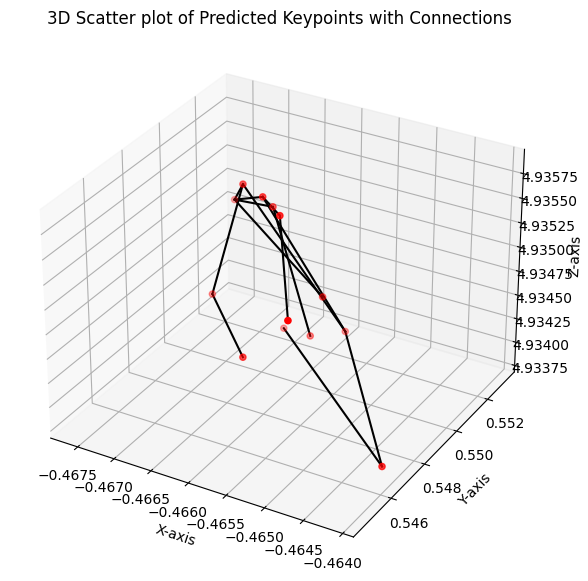

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# Assuming predicted_3d_positions is already defined
x = predicted_3d_positions[0, :, 0].numpy()
y = predicted_3d_positions[0, :, 1].numpy()
z = predicted_3d_positions[0, :, 2].numpy()

# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Creating scatter plot
ax.scatter(x, y, z, c='r', marker='o')

# Define pairs to connect
pairs = [(0, 1), (1, 4), (1, 7), (7, 10), (4, 10), (1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9), (10, 11), (11, 12)]

# Draw lines between pairs
for start, end in pairs:
    ax.plot([x[start], x[end]], [y[start], y[end]], [z[start], z[end]], 'k-')  # 'k-' for black lines

# Setting labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show plot
plt.title("3D Scatter plot of Predicted Keypoints with Connections")
plt.show()
